In [1]:
from transformer_lens import HookedTransformer
import transformer_lens.utils as utils

d:\Doctorado\Papers\Para EL paper\Workspace\synthetic_gender_datasets\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
import re
import random
import json
from datasets import Dataset, Features, Value, ClassLabel, Sequence

`get_token_position`: Get the position of a single_token in a string or sequence of tokens.

In [3]:
TOKEN_NAME_SIZE = 1
GENDER_PROPORTION_THRESHOLD = 0.7
DATASET_SIZE = 100
TEMPLATE_TYPE = "subject_with_name"
MODEL_NAME = "gpt2-small"
PROMPT_TYPE_SIZE = 10

NAMES_FILEPATH = "../datasets/names.csv"
DATASET_PATH = "../datasets/names_dataset.csv"

In [4]:
features = Features({
    "id": Value("int32"),
    "prompt_type": ClassLabel(names=[f"type_{i}" for i in range(PROMPT_TYPE_SIZE)]),
    "prompts":{
        "org_prompt": Value("string"),
        "corr_prompt": Value("string"),
        "ablated_prompt": Value("string")
    },
    "subject":{
        "token_idxs": Sequence(Value("int32")),
        "tokens": Sequence(Value("string")),
        "pos": Sequence(Value("int32"))
    },
    "end":{
        "token_idx": Value("int32"),
        "token": Value("string"),
        "pos": Value("int32")
    },
    "expected_token_id": Value("int32")
})

shared_config = {
    "F": {"token": " she",
          "token_id": 184
        },
    "M": {"token": " he",
          "token_id": 190
        }
}

In [5]:
df = pd.read_csv(NAMES_FILEPATH)
df.head()

,name,F,M,F_prop,M_prop,gpt2-small,gpt2-small-size
0,Aaban,0,87,0.0,1.0,"317,45094",2
1,Aabha,28,0,1.0,0.0,"317,397,3099",3
2,Aabid,0,5,0.0,1.0,"317,397,312",3
3,Aabriella,15,0,1.0,0.0,"317,397,380,12627",4
4,Aada,5,0,1.0,0.0,"317,4763",2


In [ ]:
def fill_prompt(prompt: str, 
                fillers: dict) -> str:
    """
    Fills a prompt template by replacing placeholders with actual values.

    Args:
        prompt (str): The prompt template containing placeholders in square brackets.
        name (str): The name to insert into the prompt.
        fillers (dict): Dictionary with possible replacements for placeholders.

    Returns:
        str: The filled prompt with all placeholders replaced.
    """
    elems = re.findall(r"\[(.*?)\]", prompt)
    for elem in elems:
        if elem in fillers:
            prompt = re.sub(rf"\[{elem}\]", random.choice(fillers[elem]), prompt)

    return prompt

In [17]:
def get_prompts(df: pd.DataFrame, prompt: str) -> pd.DataFrame:
    return pd.DataFrame({
        "original_prompt": df.apply(lambda row: re.sub(r"\[name\]", row["name_1"], prompt), axis=1),
        "corrupted_prompt": df.apply(lambda row: re.sub(r"\[name\]", row["name_2"], prompt), axis=1),
        "ablation_prompt": df.apply(lambda row: re.sub(r"\[name\]", "someone", prompt), axis=1)
    })

def get_name_token_info(model: HookedTransformer, 
                        df: pd.DataFrame, 
                        name_col: str = "name_1", 
                        prompt_col: str = "original_prompt") -> pd.DataFrame:
    """
    Returns token ids, token strings, and token positions for just the name (not the whole prompt) using the provided model.

    Args:
        model: The language model used for tokenization.
        df: DataFrame containing at least the columns with names and prompts.
        name_col: Name of the column containing the name. Default is "name".
        prompt_col: Name of the column containing the prompt. Default is "prompt".

    Returns:
        pd.DataFrame: DataFrame with columns 'name', 'token_ids', 'token_strs', 'token_positions'.
    """
    results = []
    for _, row in df.iterrows():
        name = row[name_col]
        prompt = row[prompt_col]
        
        # Tokenize the name
        name_tokens = model.to_tokens(f" {name}", prepend_bos=False)[0].tolist()
        name_token_strs = model.to_str_tokens(f" {name}", prepend_bos=False)
        
        # Find positions of name tokens in the prompt
        positions = [ model.get_token_position(single_token=int(token), input=prompt, prepend_bos=True) for token in name_tokens ]

        results.append({
            "name": name,
            "token_ids": name_tokens,
            "token_strs": name_token_strs,
            "token_positions": positions
        })
        
    return pd.DataFrame(results)

def create_dataset(names: pd.DataFrame,
                   model: HookedTransformer,
                   prompt: str,
                   dataset_size: int = DATASET_SIZE,
                   template_type: str = TEMPLATE_TYPE,
                   gdr_prop_thres: float = GENDER_PROPORTION_THRESHOLD
                   ) -> pd.DataFrame:
    """
    Creates a dataset by generating prompts and collecting model responses.

    Args:
        names (pd.DataFrame): DataFrame containing names for prompt generation.
        model (HookedTransformer): The model used for generating responses.
        prompt (str): The prompt template to use for generation.
        dataset_size (int): The desired size of the dataset.
        template_type (str): The type of template to use.
        gdr_prop_thres (float): The threshold for gender proportion in the dataset.

    Returns:
        Dataset: The generated dataset.
    """
    males   = names[ names["M_prop"] >= gdr_prop_thres ]
    females = names[ names["F_prop"] >= gdr_prop_thres ]

    sampled_males   = males.sample(n=dataset_size // 2, weights="M_prop", replace=False)
    sampled_females = females.sample(n=dataset_size // 2, weights="F_prop", replace=False)

    data_1 = pd.concat([sampled_males, sampled_females], axis=0).reset_index(drop=True)
    data_2 = pd.concat([sampled_females, sampled_males], axis=0).reset_index(drop=True)
    data_1 = data_1.add_suffix("_1")
    data_2 = data_2.add_suffix("_2")

    data = pd.concat([data_1, data_2], axis=1).reset_index(drop=True)


    data = data.assign(**get_prompts(data, prompt))
    #data = data.assign(**get_name_token_info(model, data))
    
    return data

In [ ]:
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer


In [19]:
with open("../src/json/templates_he_she.json", "r", encoding="utf-8") as f:
    jdata = json.load(f)

    df_filtered = df[ df[f"{MODEL_NAME}-size"] == TOKEN_NAME_SIZE ]


    prompt = random.choice(jdata["templates"][TEMPLATE_TYPE]["prompt_templates"])
    complements = jdata["complements"]
    prompt = fill_prompt(prompt, complements)

    data = create_dataset(df_filtered, model, prompt)

In [21]:
jdata["complements"]

{'freq': ['The other day',
  'As far as I know,',
  'The moment',
  'When',
  'Last time',
  'Earlier today,',
  'Not long ago,',
  'A few days back,',
  'Back then,',
  'From that day on,',
  'In the past,',
  'At that moment,',
  'From what I remember,',
  "If I'm not mistaken,",
  'As I recall,',
  "From what I've heard,",
  'As people say,',
  'Before anyone noticed,',
  'In that place,',
  'At the meeting,',
  'On the way home,',
  'During the trip,',
  'While at work,',
  'At school,',
  'In the office,',
  'During the event,',
  'At the party,',
  'Having arrived there,',
  'Having a clear purpose,',
  'Without knowing the details,',
  'In a moment of clarity,',
  'In a sudden realization,',
  'In a flash of insight,',
  'In a burst of inspiration,',
  'In a moment of truth,'],
 'verb': ['announced',
  'confessed',
  'admitted',
  'revealed',
  'declared',
  'mentioned',
  'acknowledged',
  'said',
  'decided'],
 'comp': ['to the audience',
  'to the crowd',
  'to the people',
 

In [ ]:
with open("../src/json/templates_he_she.json", "r", encoding="utf-8") as f:
    jdata = json.load(f)

    df_filtered = df[ df[f"{MODEL_NAME}-size"] == TOKEN_NAME_SIZE ]

    for _ in range(PROMPT_TYPE_SIZE):
        prompt = random.choice(jdata["templates"][TEMPLATE_TYPE]["prompt_templates"])
        complements = jdata["complements"]

        prompt = fill_prompt(prompt, complements)

        
        

In [ ]:
all_names = (df
 .groupby("name")
 .agg({"name": "count"})
 .rename(columns={"name": "count"})
 .reset_index()
 .sort_values(by="count", ascending=False)
 )

neutral_names = all_names[all_names["count"] > 1]["name"].values.tolist()

df_neutral = df[df["name"].isin(neutral_names)].copy()
df_neutral_pivot = df_neutral.pivot_table(
    index="name",
    columns="gender",
    values="number",
    aggfunc="sum",
    fill_value=0
).reset_index()

df_neutral_pivot["F"] = abs(df_neutral_pivot["F"] - df_neutral_pivot["M"])
df_neutral_pivot = df_neutral_pivot.sort_values(by="diff")
df_neutral_pivot

gender,name,F,M,diff
9406,Terae,5,5,0
7098,Munachi,11,11,0
7115,Murtha,5,5,0
7117,Music,6,6,0
7128,Mychel,10,10,0
...,...,...,...,...
6704,Mary,4118147,15158,4102989
6921,Michael,21641,4326215,4304574
8213,Robert,20099,4803587,4783488
4735,John,21657,5096818,5075161


In [128]:
#df = df.drop_duplicates(subset="name", keep=False)
df[ df["name"] == "Jamie" ]

,name,gender,number,gpt2-small
260,Jamie,F,266522,17826
699,Jamie,M,84703,17826


In [129]:
df["gpt2-small-size"] = df["gpt2-small"].apply(lambda x: len(x.split(",")))

In [130]:
import matplotlib.pyplot as plt

df["number"].describe()

count    1.053870e+05
mean     3.236929e+03
std      5.241932e+04
min      5.000000e+00
25%      1.100000e+01
50%      4.400000e+01
75%      2.310000e+02
max      5.122407e+06
Name: number, dtype: float64

In [131]:
df = df[df["number"] > 231]

In [133]:
def to_token_ids(model: HookedTransformer, name: str) -> str:
    """
    Converts a given name string into a comma-separated string of token IDs using the provided model.

    Args:
        model (HookedTransformer): The language model used for tokenization.
        name (str): The name to be tokenized.

    Returns:
        str: A comma-separated string of token IDs representing the input name.
    """
    tokens = model.to_tokens(f" {name}", prepend_bos=False)[0].tolist()
    return ",".join([str(t) for t in tokens])

# df["gpt2-small"] = df["name"].apply(lambda x: to_token_ids(model, x))

In [134]:
# example_prompt = "In a burst of inspiration, Mary announced in a nervous voice what"
# example_answer = " he"
# utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True, top_k=10)

In [ ]:
def fill_prompt(prompt: str, template_config: dict) -> str:
    """
    Fills a prompt template by replacing placeholders with actual values.

    Args:
        prompt (str): The prompt template containing placeholders in square brackets.
        name (str): The name to insert into the prompt.
        template_config (dict): Dictionary with possible replacements for placeholders.

    Returns:
        str: The filled prompt with all placeholders replaced.
    """
    elems = re.findall(r"\[(.*?)\]",prompt)
    for elem in elems:
        if elem in template_config:
            prompt = re.sub(rf"\[{elem}\]", random.choice(template_config[elem]), prompt)

    return prompt

def get_ans_tokens(ans: dict, model: HookedTransformer) -> dict:
    """
    Converts answer strings to their corresponding token IDs using the model.

    Args:
        ans (dict): Dictionary mapping keys (e.g., gender) to answer strings.
        model (HookedTransformer): The language model used for tokenization.

    Returns:
        dict: Dictionary mapping keys to the first token ID of each answer string.
    """
    return { k: model.to_tokens(f" {v}", prepend_bos=False)[0].tolist()[0] for k,v in ans.items() }

def get_opposite_gender(gender: str) -> str:
    """
    Returns the opposite gender.

    Args:
        gender (str): "M" for male or "F" for female.

    Returns:
        str: "F" if input is "M", otherwise "M".
    """
    return "F" if gender=="M" else "M"

def get_token_pos(prompt: str, token_str: str) -> str:
    """
    Finds the positions of tokens in a prompt.

    Args:
        prompt (str): The prompt string.
        token_str (str): Comma-separated string of token IDs.

    Returns:
        list: List of positions of each token in the prompt.
    """
    tokens = token_str.split(",")
    pos = [ model.get_token_position(single_token=int(token), input=prompt, prepend_bos=True) for token in tokens ]
    return ",".join([str(p) for p in pos])

def create_dataset(model: HookedTransformer, 
                   df: pd.DataFrame, 
                   template_config: dict, 
                   dataset_size: int = 1000, 
                   subject_token_size: int = 2) -> dict:
    """
    Creates a dataset dictionary for language model probing.

    Args:
        model (HookedTransformer): The language model.
        df (pd.DataFrame): DataFrame containing names and metadata.
        template_config (dict): Configuration for templates and answers.
        dataset_size (int): Number of samples to generate.
        subject_token_size (int): Number of tokens for subject names.

    Returns:
        dict: Dictionary containing dataset fields for further processing.
    """
    ans_tokens = get_ans_tokens(template_config["ans"], model)
    prompt = random.choice(template_config["templates"])

    all_males   = df[ (df["gender"] == "M") & (df["gpt2-small-size"] == subject_token_size) ] 
    all_females = df[ (df["gender"] == "F") & (df["gpt2-small-size"] == subject_token_size) ] 

    males   = all_males.sample(n=dataset_size // 2, weights="number", replace=True)
    females = all_females.sample(n=dataset_size // 2, weights="number", replace=True)
    
    data_1 = pd.concat([males, females], axis=0).reset_index(drop=True)
    data_2 = pd.concat([females, males], axis=0).reset_index(drop=True)
    data_1 = data_1.add_suffix("_1")
    data_2 = data_2.add_suffix("_2")

    data = pd.concat([data_1, data_2], axis=1).reset_index(drop=True)

    data["pre-prompt"] = [fill_prompt(prompt, template_config) for _ in range(len(data) // 2)] * 2
    data["prompt"]     = data.apply(lambda row: re.sub(rf"\[name\]", row["name_1"], row["pre-prompt"]), axis=1) 
    data["corrupted_prompt"] = data.apply(lambda row: re.sub(rf"\[name\]", row["name_2"], row["pre-prompt"]), axis=1) 
    data["ablation_prompt"] = data.apply(lambda row: re.sub(rf"\[name\]", "_", row["pre-prompt"]), axis=1)
    data["expected_token"] = data.apply(lambda row: template_config["ans"][row["gender_1"]], axis=1)
    data["unexpected_token"] = data.apply(lambda row: template_config["ans"][row["gender_2"]], axis=1)
    data["expected_token_id"] = data.apply(lambda row: ans_tokens[row["gender_1"]], axis=1)
    data["unexpected_token_id"] = data.apply(lambda row: ans_tokens[row["gender_2"]], axis=1)
    data["subject_token_pos"] = data.apply(lambda row: get_token_pos(row["prompt"], row["gpt2-small_1"]), axis=1)
    data["prompt_type"] = data["subject_token_pos"].astype('category').cat.codes

    cols = ["prompt", "corrupted_prompt", "ablation_prompt", "expected_token", "unexpected_token", "expected_token_id", "unexpected_token_id", "subject_token_pos", "prompt_type"]
    return data[ cols ].to_dict(orient="list")

In [136]:
# CONFIG
dataset = "subject_pron"
dataset_size = 1000
subject_token_sizes = [1,2,3]

In [137]:
with open("../src/json/templates.json", "r", encoding="utf-8") as f:
    jdata = json.load(f)
    datasets = []

    for subject_token_size in subject_token_sizes:
        print(f"Creating dataset for subject_token_size={subject_token_size}...")
        mydict = create_dataset(model, df, jdata[dataset], 
                                dataset_size=dataset_size, subject_token_size=subject_token_size)
        ds = Dataset.from_dict(mydict)
        ds.save_to_disk(f"../datasets/{dataset}_{subject_token_size}_tokens")
        datasets.append(ds)

Creating dataset for subject_token_size=1...


Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 62476.60 examples/s]


Creating dataset for subject_token_size=2...


Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 62142.44 examples/s]


Creating dataset for subject_token_size=3...


Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<?, ? examples/s]


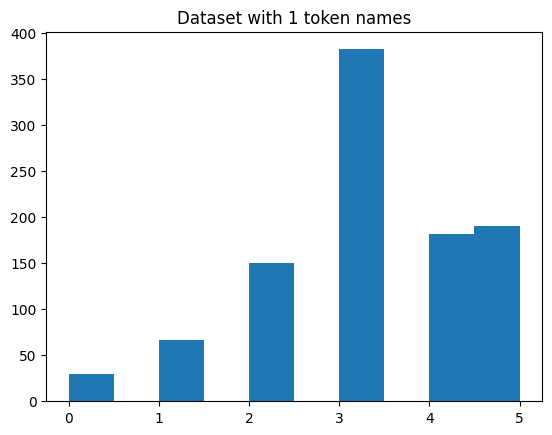

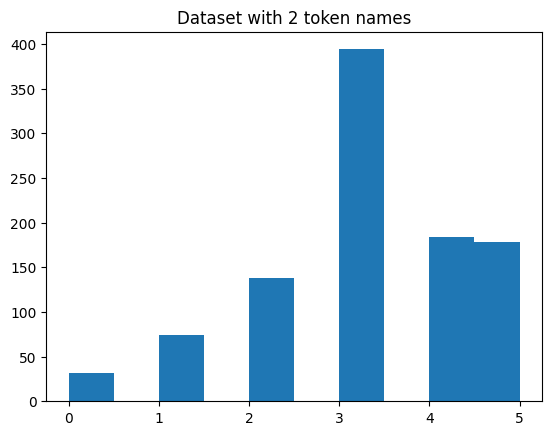

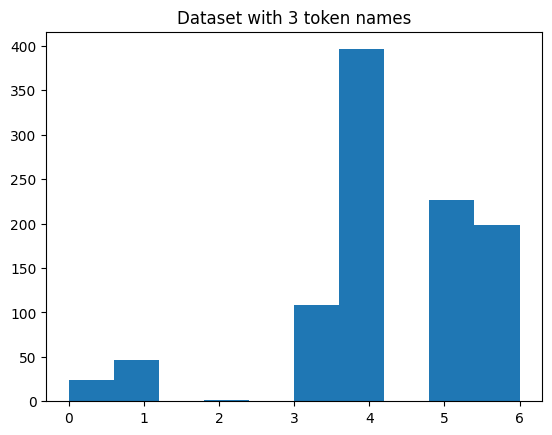

In [138]:
import matplotlib.pyplot as plt

for idx, ds in enumerate(datasets):
    plt.hist(ds["prompt_type"])
    plt.title(f"Dataset with {idx+1} token names")
    plt.show()